## Poisoning attack with MNIST dataset

For poisoning attacks the parameters are much simpler. We set the the bounds 
 of the attack space and the number of adversarial points to generate, 
 50 in this example. Lastly, we chose the  parameters for this 
 specific optimization problem.

*Read more about the attack in this paper: https://arxiv.org/pdf/1206.6389.pdf.*
 

In [1]:
from svm_model import *

Accuracy on testing dataset: 99.00%


In [9]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

# Let's define a convenience function to easily plot the MNIST dataset
def show_digits(samples, preds, labels, digs, n_display=8):
    samples = samples.atleast_2d()
    n_display = min(n_display, samples.shape[0])
    fig = CFigure(width=n_display*2, height=3)
    for idx in range(n_display):
        fig.subplot(2, n_display, idx+1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap='gray')
        fig.sp.title("{} ({})".format(digs[labels[idx].item()], digs[preds[idx].item()]),
                     color=("green" if labels[idx].item()==preds[idx].item() else "red"))
    fig.show()


Attack started...
Attack complete!
Original accuracy on test set: 99.00%
Accuracy after attack on test set: 93.00%


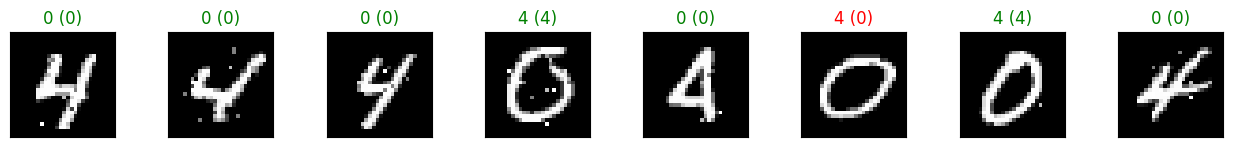

In [11]:
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
n_poisoning_points = 15  # Number of poisoning points to generate
random_state=999
# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.25,
    'eta_min': 2.0,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=model,
                                  training_data=training_dataset,
                                  val=validation_dataset,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)
pois_attack.n_points = n_poisoning_points  # Number of points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, _, pois_points_ds, _ = pois_attack.run(testing_dataset.X, testing_dataset.Y)
print("Attack complete!")

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=testing_dataset.Y, y_pred=model.predict(testing_dataset.X))
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=testing_dataset.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))

# Training of the poisoned classifier for visualization purposes
pois_clf = model.deepcopy()
pois_tr = training_dataset.append(pois_points_ds)  # Join the training set with the poisoning points
pois_clf.fit(pois_tr.X, pois_tr.Y)

show_digits(pois_points_ds.X, pois_clf.predict(pois_points_ds.X), 
            pois_points_ds.Y, digits_classifying)

#### We can see that the classifier trained on the MNIST dataset has been successfully poisoned. To increase the attack power, more poisoning points can be crafted, at the expense of a much slower optimization process.

#### In poisoning attacks, our model will generate adversarial examples i.e create fake data that represents 4 as 0 and 0 as 4. These poisonous data points once appended to the training set, the ML model will even train on poisonous data thereby predicting wrong values.

In the above case 0 was predicted as 0, but its true label is 4(as it is a poisonous point)